# 🔮🧠 FNO + RNN Combo for 5G Throughput Forecasting

In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [2]:

# Load and preprocess data
df = pd.read_csv(r"C:\Users\axxiv\Desktop\PI\mm-5G-prepared.csv")
df['Throughput_smoothed'] = df['Throughput'].rolling(window=5, min_periods=1).mean()

scaler = MinMaxScaler()
data = scaler.fit_transform(df[['Throughput_smoothed']].dropna().values).flatten()


In [3]:

# Create dataset: sequence → next step
input_len = 64
output_len = 1
X, Y = [], []
for i in range(len(data) - input_len - output_len + 1):
    X.append(data[i:i+input_len])
    Y.append(data[i+input_len:i+input_len+output_len])
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, L, 1)
Y = torch.tensor(Y, dtype=torch.float32)

train_size = int(0.8 * len(X))
train_X, train_Y = X[:train_size], Y[:train_size]
val_X, val_Y = X[train_size:], Y[train_size:]


C:\Users\axxiv\AppData\Local\Temp\ipykernel_26076\2312240500.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (B, L, 1)


In [4]:

# FNO + GRU Combo Model
class FNO_GRU(nn.Module):
    def __init__(self, seq_len, in_channels=1, fno_width=64, gru_hidden=32):
        super().__init__()
        self.fc0 = nn.Linear(in_channels, fno_width)
        self.conv1 = nn.Conv1d(fno_width, fno_width, 1)
        self.conv2 = nn.Conv1d(fno_width, fno_width, 1)
        self.gru = nn.GRU(fno_width, gru_hidden, batch_first=True)
        self.fc_out = nn.Linear(gru_hidden, output_len)

    def forward(self, x):
        x = self.fc0(x)             # (B, L, fno_width)
        x = x.permute(0, 2, 1)      # (B, fno_width, L)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)      # (B, L, fno_width)
        _, h_n = self.gru(x)        # (1, B, hidden)
        return self.fc_out(h_n.squeeze(0))  # (B, output_len)

model = FNO_GRU(seq_len=input_len)


In [5]:

# Training
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(25):
    model.train()
    pred = model(train_X)
    loss = loss_fn(pred, train_Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(val_X)
        val_loss = loss_fn(val_pred, val_Y)
    print(f"Epoch {epoch+1}: Train Loss = {loss.item():.4f} | Val Loss = {val_loss.item():.4f}")


Epoch 1: Train Loss = 0.1725 | Val Loss = 0.1081
Epoch 2: Train Loss = 0.1305 | Val Loss = 0.0796
Epoch 3: Train Loss = 0.0962 | Val Loss = 0.0602
Epoch 4: Train Loss = 0.0712 | Val Loss = 0.0499
Epoch 5: Train Loss = 0.0554 | Val Loss = 0.0484
Epoch 6: Train Loss = 0.0487 | Val Loss = 0.0536
Epoch 7: Train Loss = 0.0493 | Val Loss = 0.0612
Epoch 8: Train Loss = 0.0536 | Val Loss = 0.0663
Epoch 9: Train Loss = 0.0570 | Val Loss = 0.0661
Epoch 10: Train Loss = 0.0567 | Val Loss = 0.0613
Epoch 11: Train Loss = 0.0527 | Val Loss = 0.0541
Epoch 12: Train Loss = 0.0469 | Val Loss = 0.0462
Epoch 13: Train Loss = 0.0407 | Val Loss = 0.0390
Epoch 14: Train Loss = 0.0352 | Val Loss = 0.0332
Epoch 15: Train Loss = 0.0311 | Val Loss = 0.0290
Epoch 16: Train Loss = 0.0283 | Val Loss = 0.0261
Epoch 17: Train Loss = 0.0265 | Val Loss = 0.0241
Epoch 18: Train Loss = 0.0253 | Val Loss = 0.0223
Epoch 19: Train Loss = 0.0240 | Val Loss = 0.0205
Epoch 20: Train Loss = 0.0224 | Val Loss = 0.0185
Epoch 21:

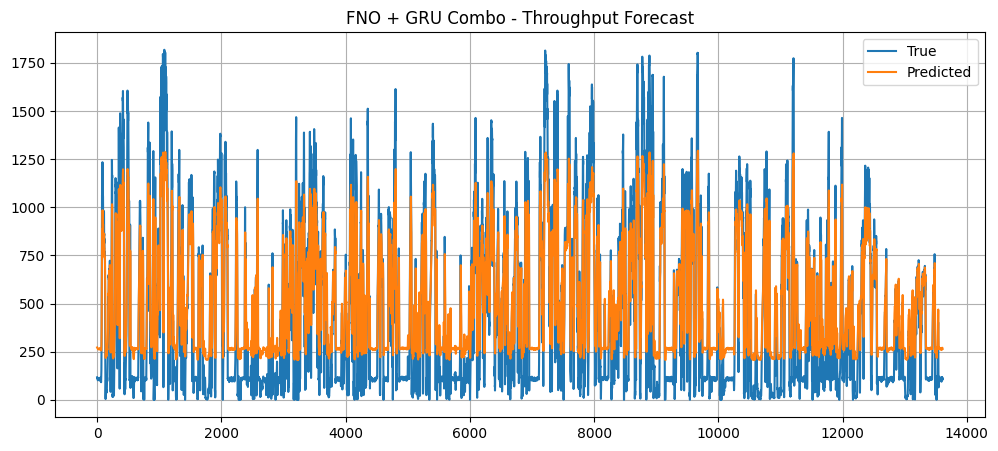

In [6]:

# Plot predictions vs ground truth
with torch.no_grad():
    preds = model(val_X).squeeze().numpy()
    true = val_Y.squeeze().numpy()

preds_inv = scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
true_inv = scaler.inverse_transform(true.reshape(-1, 1)).flatten()

plt.figure(figsize=(12,5))
plt.plot(true_inv, label='True')
plt.plot(preds_inv, label='Predicted')
plt.title("FNO + GRU Combo - Throughput Forecast")
plt.grid(True)
plt.legend()
plt.show()
